# Tutorial: Pseudobulk eQTL Analysis with `cellink`

This tutorial demonstrates how to perform pseudobulk eQTL analysis using the `cellink` package, which integrates single-cell transcriptomics with genotype data. We focus on one cell type and test for cis-eQTLs across the genome, illustrating key steps such as pseudobulk aggregation, dimensionality reduction, filtering, and linear modeling.

This notebook assumes familiarity with single-cell data processing and basic statistical genetics concepts (e.g., eQTLs, PCA). If you're new to `cellink`, we recommend reviewing the [documentation page](#) for a conceptual overview of the package.

## Environment Setup

We begin by importing necessary libraries and defining key parameters for our analysis. `cellink` provides utilities that extend `AnnData` to handle both donor-level genotype data and single-cell RNA-seq data efficiently.

In [14]:
import gc
import warnings

import anndata as ad
import scanpy as sc
import dask.array as da
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection
from tqdm.auto import tqdm

import cellink as cl
from cellink._core import DAnn, GAnn
from cellink.at.gwas import GWAS
from cellink.utils import column_normalize, gaussianize
from cellink.resources import get_dummy_onek1k

In [15]:
n_gpcs = 20
n_epcs = 15
batch_e_pcs_n_top_genes = 2000
chrom = 22
cis_window = 500_000
cell_type = "CD8 Naive"
celltype_key = "predicted.celltype.l2"
pb_gex_key = f"PB_{cell_type}"  # pseudobulk expression in dd.G.obsm[key_added]
original_donor_col = "donor_id"
min_percent_donors_expressed = 0.1
do_debug = False

## Load and Prepare Data

Here, we load a prepared dataset (`onek1k`) that includes genotype and expression information from human donors. We also extract gene annotations using Ensembl via `pybiomart`, which are essential for defining cis-windows during eQTL analysis. (This is a subset of the full OneK1K dataset, which can be downloaded, and prepared using `get_onek1k()`)

In [16]:
dd = get_dummy_onek1k(config_path="../../src/cellink/resources/config/dummy_onek1k.yaml")
dd

[2025-12-29 01:56:42,850] INFO:root: /Users/larnoldt/cellink_data/dummy_onek1k/dummy_onek1k.dd.h5 already exists
[2025-12-29 01:56:42,850] INFO:root: Veryifying checksum
[2025-12-29 01:56:45,049] INFO:root: Loaded dummy OneK1K dataset: (100, 146939, 125366, 34073)


╔═ DonorData(n_donors=100, n_cells_per_donor=[613-2,731], donor_id='donor_id') ═══════════════════════════════╗
║ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓ ║
║ ┃ G (donors)                                         ┃ C (cells)                                          ┃ ║
║ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩ ║
║ │ AnnData object with n_obs × n_vars = 100 × 146,939 │ View of AnnData object with n_obs × n_vars =       │ ║
║ │                                                    │ 125,366 × 34,073                                   │ ║
║ │     var: 'chrom', 'pos', 'a0', 'a1', 'AC',         │     obs: 'orig.ident', 'nCount_RNA',               │ ║
║ │ 'AC_Hemi', 'AC_Het', 'AC_Hom', 'AF', 'AN', 'ER2',  │ 'nFeature_RNA', 'percent.mt', 'donor_id',          │ ║
║ │ 'ExcHet', 'HWE', 'IMPUTED', 'maf', 'NS', 'R2',     │ 'pool_number', 'predicted.celltype.l2',            │ ║
║ │ 'TYPED', 'TYPED_ONLY', 'id', 'id_mask', 'length',  │ 'predicted.celltype.l2.score', 'age',              │ ║
║ │ 'quality', 'pos_hg19', 'id_hg19'                   │ 'organism_ontology_term_id',                       │ ║
║ │                                                    │ 'tissue_ontology_term_id',                         │ ║
║ │                                                    │ 'assay_ontology_term_id',                          │ ║
║ │                                                    │ 'disease_ontology_term_id',                        │ ║
║ │                                                    │ 'cell_type_ontology_term_id',                      │ ║
║ │                                                    │ 'self_reported_ethnicity_ontology_term_id',        │ ║
║ │                                                    │ 'development_stage_ontology_term_id',              │ ║
║ │                                                    │ 'sex_ontology_term_id', 'is_primary_data',         │ ║
║ │                                                    │ 'suspension_type', 'tissue_type', 'cell_type',     │ ║
║ │                                                    │ 'assay', 'disease', 'organism', 'sex', 'tissue',   │ ║
║ │                                                    │ 'self_reported_ethnicity', 'development_stage',    │ ║
║ │                                                    │ 'observation_joinid'                               │ ║
║ │     uns: 'kinship'                                 │     var: 'vst.mean', 'vst.variance',               │ ║
║ │                                                    │ 'vst.variance.expected',                           │ ║
║ │                                                    │ 'vst.variance.standardized', 'vst.variable',       │ ║
║ │                                                    │ 'feature_is_filtered', 'feature_name',             │ ║
║ │                                                    │ 'feature_reference', 'feature_biotype',            │ ║
║ │                                                    │ 'feature_length', 'feature_type', 'start', 'end',  │ ║
║ │                                                    │ 'chrom'                                            │ ║
║ │     obsm: 'gPCs'                                   │     uns: 'cell_type_ontology_term_id_colors',      │ ║
║ │                                                    │ 'citation', 'default_embedding',                   │ ║
║ │                                                    │ 'schema_reference', 'schema_version', 'title'      │ ║
║ │     varm: 'filter'                                 │     obsm: 'X_azimuth_spca', 'X_azimuth_umap',      │ ║
║ │                                                    │ 'X_harmony', 'X_pca', 'X_umap'                     │ ║
║ │                                                    │     varm: 'PCs'                                    │ ║
║ └────────────────────────────────────────────────────┴────────────────────────

In [17]:
dd.G.obsm["gPCs"] = dd.G.obsm["gPCs"][dd.G.obsm["gPCs"].columns[:n_gpcs]]

## Normalize and Filter Expression Data

We normalize single-cell expression using total-count normalization and log transformation. We then filter the dataset to only include cells of a specific type (`CD8 Naive`). This step ensures we're analyzing homogeneous populations, which increases power in eQTL detection.

In [18]:
sc.pp.normalize_total(dd.C)
sc.pp.log1p(dd.C)
sc.pp.normalize_total(dd.C)

mdata = sc.get.aggregate(dd.C, by=DAnn.donor, func="mean")
mdata.X = mdata.layers.pop("mean")

sc.pp.highly_variable_genes(mdata, n_top_genes=batch_e_pcs_n_top_genes)
sc.tl.pca(mdata, n_comps=n_epcs)

dd.G.obsm["ePCs"] = mdata[dd.G.obs_names].obsm["X_pca"]

/opt/miniconda3/envs/single_cell_base3/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [19]:
dd = dd[..., dd.C.obs[celltype_key] == cell_type, :].copy()
dd

╔═ DonorData(n_donors=100, n_cells_per_donor=[1-302], donor_id='donor_id') ═══════════════════════════════════╗
║ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓ ║
║ ┃ G (donors)                                         ┃ C (cells)                                          ┃ ║
║ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩ ║
║ │ AnnData object with n_obs × n_vars = 100 × 146,939 │ AnnData object with n_obs × n_vars = 4,756 ×       │ ║
║ │                                                    │ 34,073                                             │ ║
║ │     var: 'chrom', 'pos', 'a0', 'a1', 'AC',         │     obs: 'orig.ident', 'nCount_RNA',               │ ║
║ │ 'AC_Hemi', 'AC_Het', 'AC_Hom', 'AF', 'AN', 'ER2',  │ 'nFeature_RNA', 'percent.mt', 'donor_id',          │ ║
║ │ 'ExcHet', 'HWE', 'IMPUTED', 'maf', 'NS', 'R2',     │ 'pool_number', 'predicted.celltype.l2',            │ ║
║ │ 'TYPED', 'TYPED_ONLY', 'id', 'id_mask', 'length',  │ 'predicted.celltype.l2.score', 'age',              │ ║
║ │ 'quality', 'pos_hg19', 'id_hg19'                   │ 'organism_ontology_term_id',                       │ ║
║ │                                                    │ 'tissue_ontology_term_id',                         │ ║
║ │                                                    │ 'assay_ontology_term_id',                          │ ║
║ │                                                    │ 'disease_ontology_term_id',                        │ ║
║ │                                                    │ 'cell_type_ontology_term_id',                      │ ║
║ │                                                    │ 'self_reported_ethnicity_ontology_term_id',        │ ║
║ │                                                    │ 'development_stage_ontology_term_id',              │ ║
║ │                                                    │ 'sex_ontology_term_id', 'is_primary_data',         │ ║
║ │                                                    │ 'suspension_type', 'tissue_type', 'cell_type',     │ ║
║ │                                                    │ 'assay', 'disease', 'organism', 'sex', 'tissue',   │ ║
║ │                                                    │ 'self_reported_ethnicity', 'development_stage',    │ ║
║ │                                                    │ 'observation_joinid'                               │ ║
║ │     uns: 'kinship'                                 │     var: 'vst.mean', 'vst.variance',               │ ║
║ │                                                    │ 'vst.variance.expected',                           │ ║
║ │                                                    │ 'vst.variance.standardized', 'vst.variable',       │ ║
║ │                                                    │ 'feature_is_filtered', 'feature_name',             │ ║
║ │                                                    │ 'feature_reference', 'feature_biotype',            │ ║
║ │                                                    │ 'feature_length', 'feature_type', 'start', 'end',  │ ║
║ │                                                    │ 'chrom'                                            │ ║
║ │     obsm: 'gPCs', 'ePCs'                           │     uns: 'cell_type_ontology_term_id_colors',      │ ║
║ │                                                    │ 'citation', 'default_embedding',                   │ ║
║ │                                                    │ 'schema_reference', 'schema_version', 'title',     │ ║
║ │                                                    │ 'log1p'                                            │ ║
║ │     varm: 'filter'                                 │     obsm: 'X_azimuth_spca', 'X_azimuth_umap',      │ ║
║ │                                                    │ 'X_harmony', 'X_pca', 'X_umap'                     │ ║
║ │                                                    │     varm: 'PCs'        

In [20]:
gc.collect()

2380

## Pseudobulk Aggregation and ePC Calculation

We compute pseudobulk expression profiles by averaging expression across all cells from the same donor. From these profiles, we identify highly variable genes and compute expression PCs (ePCs), which will be used as covariates in the regression model to control for expression heterogeneity.

In [21]:
dd.aggregate(key_added=pb_gex_key, sync_var=True, verbose=True)
dd.aggregate(obs=["sex", "age"], func="first", add_to_obs=True)
dd

[2025-12-29 01:56:47,292] INFO:cellink._core.donordata: Aggregated X to PB_CD8 Naive
[2025-12-29 01:56:47,292] INFO:cellink._core.donordata: Observation found for 100 donors.


╔═ DonorData(n_donors=100, n_cells_per_donor=[1-302], donor_id='donor_id') ═══════════════════════════════════╗
║ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓ ║
║ ┃ G (donors)                                         ┃ C (cells)                                          ┃ ║
║ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩ ║
║ │ AnnData object with n_obs × n_vars = 100 × 146,939 │ AnnData object with n_obs × n_vars = 4,756 ×       │ ║
║ │                                                    │ 34,073                                             │ ║
║ │     obs: 'sex', 'age'                              │     obs: 'orig.ident', 'nCount_RNA',               │ ║
║ │                                                    │ 'nFeature_RNA', 'percent.mt', 'donor_id',          │ ║
║ │                                                    │ 'pool_number', 'predicted.celltype.l2',            │ ║
║ │                                                    │ 'predicted.celltype.l2.score', 'age',              │ ║
║ │                                                    │ 'organism_ontology_term_id',                       │ ║
║ │                                                    │ 'tissue_ontology_term_id',                         │ ║
║ │                                                    │ 'assay_ontology_term_id',                          │ ║
║ │                                                    │ 'disease_ontology_term_id',                        │ ║
║ │                                                    │ 'cell_type_ontology_term_id',                      │ ║
║ │                                                    │ 'self_reported_ethnicity_ontology_term_id',        │ ║
║ │                                                    │ 'development_stage_ontology_term_id',              │ ║
║ │                                                    │ 'sex_ontology_term_id', 'is_primary_data',         │ ║
║ │                                                    │ 'suspension_type', 'tissue_type', 'cell_type',     │ ║
║ │                                                    │ 'assay', 'disease', 'organism', 'sex', 'tissue',   │ ║
║ │                                                    │ 'self_reported_ethnicity', 'development_stage',    │ ║
║ │                                                    │ 'observation_joinid'                               │ ║
║ │     var: 'chrom', 'pos', 'a0', 'a1', 'AC',         │     var: 'vst.mean', 'vst.variance',               │ ║
║ │ 'AC_Hemi', 'AC_Het', 'AC_Hom', 'AF', 'AN', 'ER2',  │ 'vst.variance.expected',                           │ ║
║ │ 'ExcHet', 'HWE', 'IMPUTED', 'maf', 'NS', 'R2',     │ 'vst.variance.standardized', 'vst.variable',       │ ║
║ │ 'TYPED', 'TYPED_ONLY', 'id', 'id_mask', 'length',  │ 'feature_is_filtered', 'feature_name',             │ ║
║ │ 'quality', 'pos_hg19', 'id_hg19'                   │ 'feature_reference', 'feature_biotype',            │ ║
║ │                                                    │ 'feature_length', 'feature_type', 'start', 'end',  │ ║
║ │                                                    │ 'chrom'                                            │ ║
║ │     uns: 'kinship'                                 │     uns: 'cell_type_ontology_term_id_colors',      │ ║
║ │                                                    │ 'citation', 'default_embedding',                   │ ║
║ │                                                    │ 'schema_reference', 'schema_version', 'title',     │ ║
║ │                                                    │ 'log1p'                                            │ ║
║ │     obsm: 'gPCs', 'ePCs', 'PB_CD8 Naive'           │     obsm: 'X_azimuth_spca', 'X_azimuth_umap',      │ ║
║ │                                                    │ 'X_harmony', 'X_pca', 'X_umap'                     │ ║
║ │     varm: 'filter'                                 │     varm: 'PCs'        

## Filter Genes Based on Donor Expression Coverage

To ensure statistical robustness, we exclude genes that are not expressed in at least 10% of donors. This prevents unreliable associations driven by low expression or sparse data.

In [22]:
print(f"{pb_gex_key} shape:", dd.G.obsm[pb_gex_key].shape)
print("dd.shape:", dd.shape)

keep_genes = ((dd.G.obsm[pb_gex_key] > 0).mean(axis=0) >= min_percent_donors_expressed).values
dd = dd[..., keep_genes]
print("after filtering")
print(f"{pb_gex_key} shape:", dd.G.obsm[pb_gex_key].shape)
print("dd.shape:", dd.shape)

PB_CD8 Naive shape: (100, 34073)
dd.shape: (100, 146939, 4756, 34073)
after filtering
PB_CD8 Naive shape: (100, 11958)
dd.shape: (100, 146939, 4756, 11958)


## Prepare Covariate Matrix

We construct a covariate matrix including sex, age, genotype PCs (gPCs), and expression PCs (ePCs). These help control for confounding effects in the association analysis. Covariates are normalized before being used in the regression model.

In [23]:
F = np.concatenate(
    [
        np.ones((dd.shape[0], 1)),
        dd.G.obs[["sex"]].values - 1,
        dd.G.obs[["age"]].values,
        dd.G.obsm["gPCs"].values,
        dd.G.obsm["ePCs"],
    ],
    axis=1,
)
F[:, 2:] = column_normalize(F[:, 2:])

## Run cis-eQTL Mapping

We perform linear regression for each gene against all SNPs within a ±500kb cis-window. For each gene, we retain the top associated SNP and record statistics such as p-value, beta, and likelihood ratio test (LRT) values.

In [24]:
# alternative to dd[:, dd.G.var.chrom == str(chrom), :, dd.C.var.chrom == str(chrom)]
dd = dd.sel(G_var=dd.G.var.chrom == str(chrom), C_var=dd.C.var.chrom == str(chrom)).copy()
dd

╔═ DonorData(n_donors=100, n_cells_per_donor=[1-302], donor_id='donor_id') ═══════════════════════════════════╗
║ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓ ║
║ ┃ G (donors)                                         ┃ C (cells)                                          ┃ ║
║ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩ ║
║ │ AnnData object with n_obs × n_vars = 100 × 136,776 │ AnnData object with n_obs × n_vars = 4,756 × 318   │ ║
║ │     obs: 'sex', 'age'                              │     obs: 'orig.ident', 'nCount_RNA',               │ ║
║ │                                                    │ 'nFeature_RNA', 'percent.mt', 'donor_id',          │ ║
║ │                                                    │ 'pool_number', 'predicted.celltype.l2',            │ ║
║ │                                                    │ 'predicted.celltype.l2.score', 'age',              │ ║
║ │                                                    │ 'organism_ontology_term_id',                       │ ║
║ │                                                    │ 'tissue_ontology_term_id',                         │ ║
║ │                                                    │ 'assay_ontology_term_id',                          │ ║
║ │                                                    │ 'disease_ontology_term_id',                        │ ║
║ │                                                    │ 'cell_type_ontology_term_id',                      │ ║
║ │                                                    │ 'self_reported_ethnicity_ontology_term_id',        │ ║
║ │                                                    │ 'development_stage_ontology_term_id',              │ ║
║ │                                                    │ 'sex_ontology_term_id', 'is_primary_data',         │ ║
║ │                                                    │ 'suspension_type', 'tissue_type', 'cell_type',     │ ║
║ │                                                    │ 'assay', 'disease', 'organism', 'sex', 'tissue',   │ ║
║ │                                                    │ 'self_reported_ethnicity', 'development_stage',    │ ║
║ │                                                    │ 'observation_joinid'                               │ ║
║ │     var: 'chrom', 'pos', 'a0', 'a1', 'AC',         │     var: 'vst.mean', 'vst.variance',               │ ║
║ │ 'AC_Hemi', 'AC_Het', 'AC_Hom', 'AF', 'AN', 'ER2',  │ 'vst.variance.expected',                           │ ║
║ │ 'ExcHet', 'HWE', 'IMPUTED', 'maf', 'NS', 'R2',     │ 'vst.variance.standardized', 'vst.variable',       │ ║
║ │ 'TYPED', 'TYPED_ONLY', 'id', 'id_mask', 'length',  │ 'feature_is_filtered', 'feature_name',             │ ║
║ │ 'quality', 'pos_hg19', 'id_hg19'                   │ 'feature_reference', 'feature_biotype',            │ ║
║ │                                                    │ 'feature_length', 'feature_type', 'start', 'end',  │ ║
║ │                                                    │ 'chrom'                                            │ ║
║ │     uns: 'kinship'                                 │     uns: 'cell_type_ontology_term_id_colors',      │ ║
║ │                                                    │ 'citation', 'default_embedding',                   │ ║
║ │                                                    │ 'schema_reference', 'schema_version', 'title',     │ ║
║ │                                                    │ 'log1p'                                            │ ║
║ │     obsm: 'gPCs', 'ePCs', 'PB_CD8 Naive'           │     obsm: 'X_azimuth_spca', 'X_azimuth_umap',      │ ║
║ │                                                    │ 'X_harmony', 'X_pca', 'X_umap'                     │ ║
║ │     varm: 'filter'                                 │     varm: 'PCs'                                    │ ║
║ └────────────────────────────────────────────────────┴────────────────────────

In [25]:
results = []
if isinstance(dd.G.X, da.Array | ad._core.views.DaskArrayView):
    if dd.G.is_view:
        dd._G = dd._G.copy()  # TODO: discuss with SWEs
    dd.G.X = dd.G.X.compute()

if do_debug:
    warnings.filterwarnings("ignore", category=RuntimeWarning)

for gene, row in tqdm(dd.C.var.iterrows(), total=dd.shape[3]):
    Y = gaussianize(dd.G.obsm[pb_gex_key][[gene]].values + 1e-5 * np.random.randn(dd.shape[0], 1))

    start = max(0, row.start - cis_window)
    end = row.end + cis_window
    _G = dd.G[:, (dd.G.var.pos < end)]
    _G = _G[:, (_G.var.pos > start)]
    _G = _G[:, (_G.X.std(0) != 0)]
    G = _G.X

    gwas = GWAS(Y, F)
    gwas.test_association(G)

    snp_idx = gwas.getPv().argmin()

    def _get_top_snp(arr, snp_idx=snp_idx):
        return arr.ravel()[snp_idx].item()

    rdict = {
        "snp": _G.var.iloc[snp_idx].name,
        "egene": gene,
        "n_cis_snps": G.shape[1],
        "pv": _get_top_snp(gwas.getPv()),
        "beta": _get_top_snp(gwas.getBetaSNP()),
        "betaste": _get_top_snp(gwas.getBetaSNPste()),
        "lrt": _get_top_snp(gwas.getLRT()),
    }
    results.append(rdict)

rdf = pd.DataFrame(results)
rdf

  0%|          | 0/318 [00:00<?, ?it/s]

,snp,egene,n_cis_snps,pv,beta,betaste,lrt
0,22_17025474_T_C,ENSG00000177663,4353,0.002351,0.638167,0.209793,9.253086
1,22_17331270_T_A,ENSG00000069998,4587,0.002296,-2.017830,0.661812,9.296089
2,22_17560764_C_T,ENSG00000093072,5011,0.000060,0.918016,0.228827,16.094775
3,22_17092723_T_TTTTC,ENSG00000131100,5294,0.000397,-0.919644,0.259648,12.544946
4,22_17318639_C_T,ENSG00000099968,5378,0.000527,-0.809841,0.233605,12.018036
...,...,...,...,...,...,...,...
313,22_50170133_C_T,ENSG00000205560,3583,0.000866,2.456946,0.737668,11.093513
314,22_50394778_C_T,ENSG00000100288,3506,0.000509,-1.290082,0.371136,12.082821
315,22_50500379_TGGG_T,ENSG00000205559,3479,0.003743,-0.599831,0.206908,8.404331
316,22_50260735_G_A,ENSG00000100299,3233,0.000066,1.826103,0.457598,15.925137


## Collect and Adjust Results

We collect all results into a DataFrame and perform multiple testing correction. The Benjamini-Hochberg FDR (`qv`) is computed to identify statistically significant gene-SNP pairs.

We then count the number of genes with significant associations (FDR < 0.05).

In [26]:
rdf["pv_adj"] = np.clip(rdf["pv"] * rdf["n_cis_snps"], 0, 1)  # gene-wise Bonferroni
rdf["qv"] = fdrcorrection(rdf["pv_adj"])[1]

(rdf.qv < 0.05).sum()

2

### Manhattan Plot: Genome-wide eQTL Landscape

To visualize the genomic distribution of eQTL associations, we create a Manhattan plot showing the adjusted p-value for each gene's top SNP.

[2025-12-29 01:57:02,543] INFO:cellink.pl._at: Significant hits: ENSG00000040608, ENSG00000099956, ENSG00000100099, ENSG00000100379, ENSG00000189060, ENSG00000183172, ENSG00000100376, ENSG00000231711, ENSG00000273188


/Users/larnoldt/sc-genetics/src/cellink/pl/_at.py:251: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chr_max_bp = pvals_df.groupby(chromosome_col)[position_col].max().cumsum()
/Users/larnoldt/sc-genetics/src/cellink/pl/_at.py:276: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (chr_num, group) in enumerate(pvals_df.groupby(chromosome_col)):


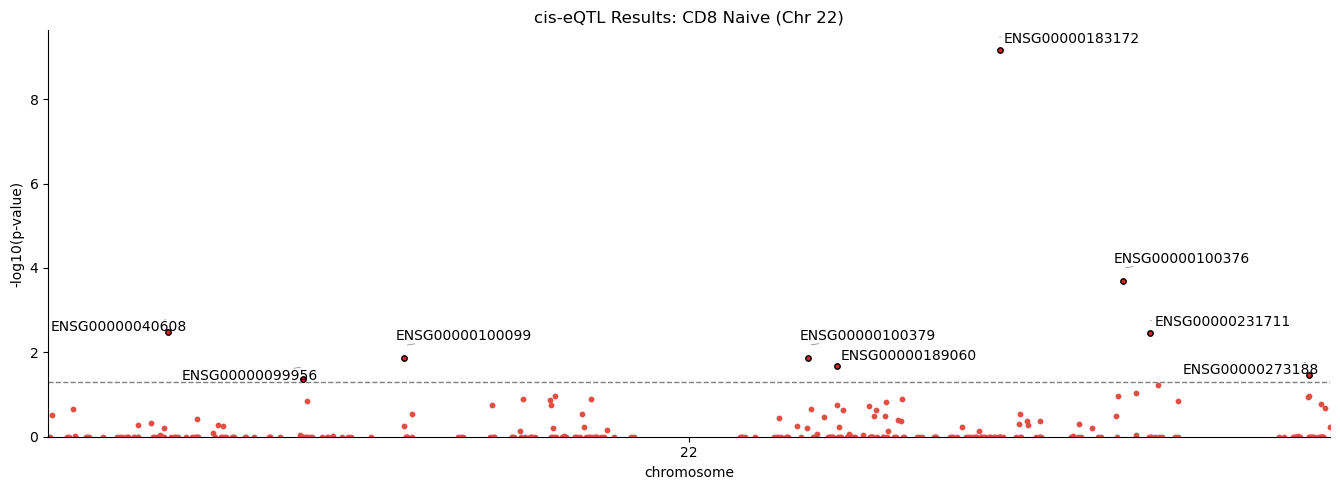

In [27]:
# Prepare data with gene positions for Manhattan plot
manhattan_df = rdf.merge(dd.C.var[[GAnn.start, GAnn.chrom]], left_on="egene", right_index=True)
manhattan_df = manhattan_df.rename(columns={GAnn.start: "pos"})

fig = cl.pl.manhattan(
    manhattan_df,
    pval_col="pv_adj",
    chromosome_col=GAnn.chrom,
    position_col="pos",
    significance_threshold=0.05,
    label_column="egene",
    title=f"cis-eQTL Results: {cell_type} (Chr {chrom})",
    figsize=(14, 5),
)

### Locus Plot: Detailed View of Top eGene

For the most significant eGene, we can create a detailed locus plot showing all tested SNPs in the cis-window.

/Users/larnoldt/sc-genetics/src/cellink/at/gwas.py:114: RuntimeWarning: divide by zero encountered in divide
  n = 1.0 / (GG - np.einsum("ij,ij->j", FG, A0iFG))
/Users/larnoldt/sc-genetics/src/cellink/at/gwas.py:115: RuntimeWarning: invalid value encountered in multiply
  M = -n * A0iFG
/Users/larnoldt/sc-genetics/src/cellink/at/gwas.py:119: RuntimeWarning: invalid value encountered in multiply
  self.beta_g += n[:, None] * GY


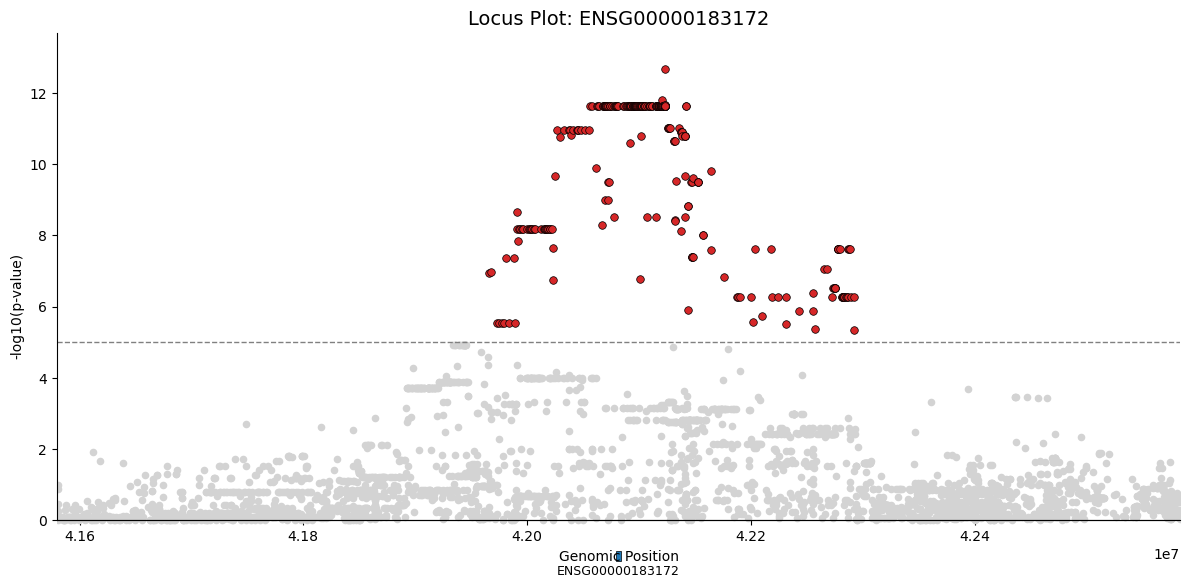

In [28]:
# Get the top eGene
top_gene = rdf.nsmallest(1, "qv").iloc[0]
top_gene_id = top_gene["egene"]
gene_row = dd.C.var.loc[top_gene_id]

# Get all SNPs tested for this gene
start = max(0, gene_row.start - cis_window)
end = gene_row.end + cis_window
gene_snps = dd.G.var[(dd.G.var.pos > start) & (dd.G.var.pos < end)].copy()

# Compute p-values for all SNPs
Y = gaussianize(dd.G.obsm[pb_gex_key][[top_gene_id]].values + 1e-5 * np.random.randn(dd.shape[0], 1))
_G = dd.G[:, gene_snps.index]
G = _G.X

gwas = GWAS(Y, F)
gwas.test_association(G)

# Create locus plot dataframe
locus_df = pd.DataFrame({"pos": gene_snps["pos"].values, "pval": gwas.getPv().ravel()}, index=gene_snps.index)

# Gene annotation dataframe
gene_df = pd.DataFrame({"start": [gene_row.start], "end": [gene_row.end], "gene": [top_gene_id]})

fig = cl.pl.locus(
    locus_df,
    gene_df=gene_df,
    pval_col="pval",
    position_col="pos",
    significance_threshold=1e-5,
    title=f"Locus Plot: {top_gene_id}",
    figsize=(12, 6),
)

### Expression by Genotype

Finally, we visualize how expression of the top eGene varies by genotype at the lead SNP across cell types.

/Users/larnoldt/sc-genetics/src/cellink/pl/_expression.py:142: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(["donor_id", "cell_type", "gene"]).mean().reset_index()
/Users/larnoldt/sc-genetics/src/cellink/pl/_expression.py:168: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot_func(data=merged, ax=ax, **plot_kwargs)


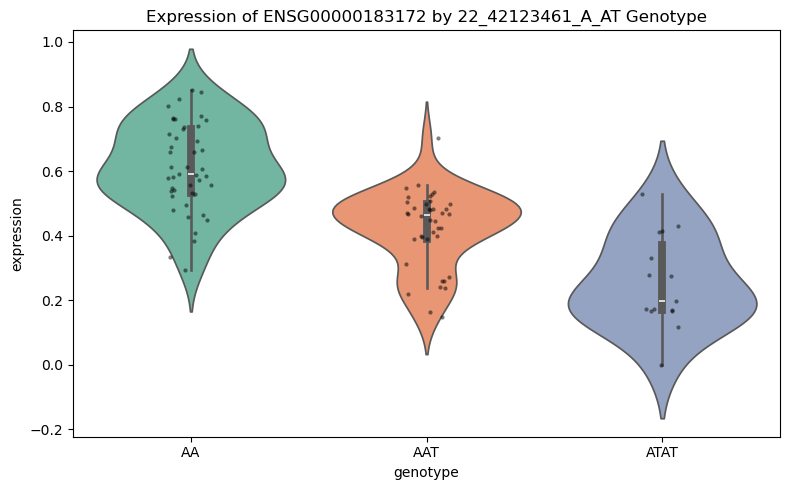

In [29]:
fig = cl.pl.expression_by_genotype(
    dd,
    snp=top_gene["snp"],
    celltype_key=celltype_key,
    gene_filter=[top_gene_id],
    mode="cell_type",
    plot_type="violin",
    show_stripplot=True,
    title=f'Expression of {top_gene_id} by {top_gene["snp"]} Genotype',
    figsize=(8, 5),
)